# NLP.F2501 Course Project 1 (Word embeddings and RNNs)

Nevin Helfenstein

# Introduction

In this notebook, I present my solution to the CommonsenseQA task. I'll train a model using word embeddings, RNNs, and other NLP techniques to achieve the best possible performance.

## Dataset Description

The CommonsenseQA dataset [(Talmor et al., 2019)](https://aclanthology.org/N19-1421/) contains 12,247 multiple-choice questions specifically designed to test commonsense reasoning. Unlike standard QA tasks, these questions require prior knowledge about how concepts relate in the real world.

Questions were created by extracting related concepts from ConceptNet and having crowd-workers author questions that require distinguishing between them. This methodology produced challenging questions that often cannot be answered through simple pattern matching.

The best baseline in the original paper (BERT-large) achieved only 56% accuracy compared to human performance of 89%, shwoing the difficulty of encoding human-like commonsense reasoning.

# Setup

First we import all the needed libraries

In [1]:
import torch
import nltk
import wandb
import logging
import re

import gensim

import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from matplotlib_venn import venn2


from datasets import load_dataset
from huggingface_hub import hf_hub_download

from collections import Counter, defaultdict
from datetime import datetime

import functools
import pickle
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn.functional as F
import time
import math

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


/home/nevin/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fixed variables

We set the random seed for all the necessary configurations  to ensure reproducibility

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Tokenizer and embedding model

I've selected FastText embeddings with the common crawl model (crawl-3dd-2m-subword) for this project for the following reasons:

* **Subword modeling** - handles unknown words & typos
* **Morphologically aware** - recognizes word relationships 
* **Massive training corpus** - 600B tokens from Common Crawl
* **Rich embeddings** - 300 dimensions, 2M word vectors
* **Proven performance** - excels in commonsense reasoning tasks
* **Well Documented** - is known in the NLP community and is very well documented

Download tokenizer files

In [3]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /home/nevin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Download the FastText model from Hugging Face (Facebook's common crawl model)

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

Load the model

In [5]:
ft_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = ft_model.wv

Create a function to get embeddings for words (retruns word vector)

In [6]:
def get_fasttext_embedding(word):
    try:
        return ft_model[word]
    except KeyError:
        return np.zeros(300)

### Data Splits

The data is available on Hugging Face: [Data](https://huggingface.co/datasets/tau/commonsense_qa).
Only the train and validation splits have an answer key, because of that we will use our own dataset splits.
We use all of the datasamples as the train set except for the last 1000 which we set as the validation set. The original validation set is set as the test set.

In [7]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data exploration

We convert to DataFrames for easier analysis

In [8]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)
test_df = pd.DataFrame(test)

datasets = {
    "Training": train_df,
    "Validation": valid_df,
    "Test": test_df
}

We check basic statistics such as average question and choice lenght for each DataFrame

In [9]:
def analyze_dataset(df, name):
    """Analyze basic statistics of a dataset split without modifying the dataframe"""
    print(f"=== {name} Set Statistics ===")
    print(f"Number of examples: {len(df)}")

    question_lengths = [len(word_tokenize(q)) for q in df['question']]
    
    print(f"Example 'choices' structure: {df['choices'].iloc[0]}")
    
    choice_lengths = []
    for choices_row in df['choices']:
        if isinstance(choices_row, list):
            try:
                row_lengths = [len(word_tokenize(choice['text'])) for choice in choices_row]
            except TypeError:
                row_lengths = [len(word_tokenize(choice)) for choice in choices_row]
        elif isinstance(choices_row, str):
            row_lengths = [len(word_tokenize(choices_row))]
        else:
            row_lengths = [0]
        
        choice_lengths.append(row_lengths)
    
    avg_choice_lengths = [np.mean(lengths) if lengths else 0 for lengths in choice_lengths]
    
    print(f"Average question length: {np.mean(question_lengths):.2f} tokens")
    print(f"Average answer choice length: {np.mean(avg_choice_lengths):.2f} tokens")
    print(f"Min/Max question length: {min(question_lengths)}/{max(question_lengths)} tokens")
    
    if 'answerKey' in df.columns:
        correct_positions = []
        for _, row in df.iterrows():
            try:
                correct_idx = next((i for i, choice in enumerate(row['choices']) 
                                if choice['label'] == row['answerKey']), -1)
            except (TypeError, KeyError):
                correct_idx = -1
            correct_positions.append(correct_idx)
        
        valid_positions = [p for p in correct_positions if p >= 0]
        if valid_positions:
            position_counts = np.bincount(valid_positions)
            print(f"Distribution of correct answers: {position_counts}")
    
    return df

train_df = analyze_dataset(train_df, "Training")
valid_df = analyze_dataset(valid_df, "Validation")
test_df = analyze_dataset(test_df, "Test")

=== Training Set Statistics ===
Number of examples: 8741
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
Average question length: 14.90 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/67 tokens
=== Validation Set Statistics ===
Number of examples: 1000
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['eat cake', 'getting drunk', 'having sex', 'cleaning rooms', 'drink too much']}
Average question length: 15.03 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 5/48 tokens
=== Test Set Statistics ===
Number of examples: 1221
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']}
Average question length: 14.73 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/60 tokens


We plot the question lenght distribution

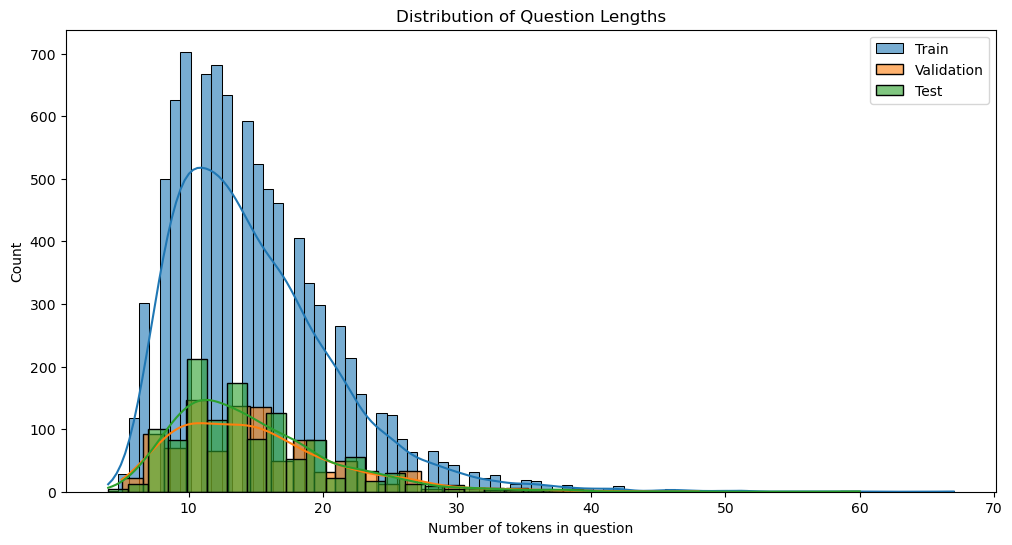

In [10]:
train_df['question_length'] = train_df['question'].apply(lambda x: len(word_tokenize(x)))
valid_df['question_length'] = valid_df['question'].apply(lambda x: len(word_tokenize(x)))
test_df['question_length'] = test_df['question'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='question_length', kde=True, label='Train', alpha=0.6)
sns.histplot(data=valid_df, x='question_length', kde=True, label='Validation', alpha=0.6)
sns.histplot(data=test_df, x='question_length', kde=True, label='Test', alpha=0.6)

plt.title('Distribution of Question Lengths')
plt.xlabel('Number of tokens in question')
plt.ylabel('Count')
plt.legend()
plt.savefig('viz/question_length_distribution.png')
plt.show()
plt.close()

We plot the answer key distribution

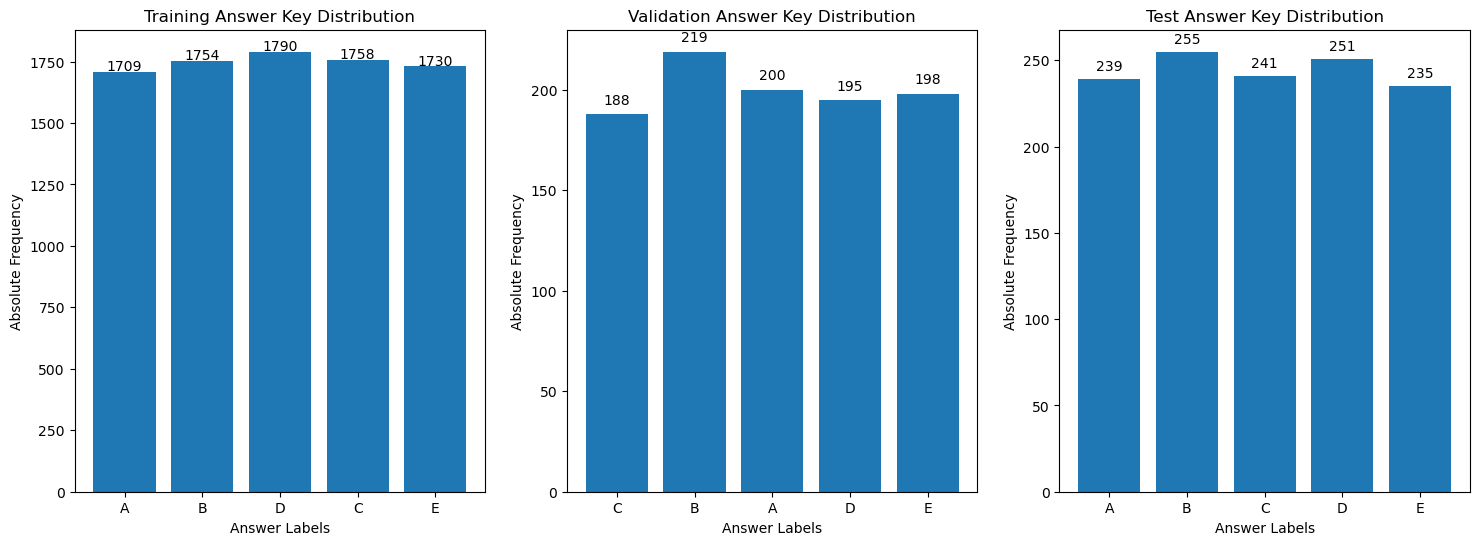

In [11]:
plt.figure(figsize=(18, 6))

for i, (split, df) in enumerate(datasets.items(), 1):
    answer_counts = Counter(df['answerKey'])
    
    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")
    
    for label, count in answer_counts.items():
        plt.text(label, count + 5, str(count), ha='center')

plt.savefig('viz/answer_key_distribution.png')
plt.show()

Analyze question types (what, how, why, etc.)

In [12]:
def get_question_type(question):
    """Extract the question word from a question"""
    question = question.lower().strip()
    question_words = ['what', 'which', 'who', 'how', 'why', 'when', 'where']
    
    for word in question_words:
        if question.startswith(word) or f" {word} " in question:
            return word
    
    return 'other'

train_df['question_type'] = train_df['question'].apply(get_question_type)
valid_df['question_type'] = valid_df['question'].apply(get_question_type)
test_df['question_type'] = test_df['question'].apply(get_question_type)

Columns in Training dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']
Columns in Validation dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']
Columns in Test dataset: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'question_length', 'question_type']


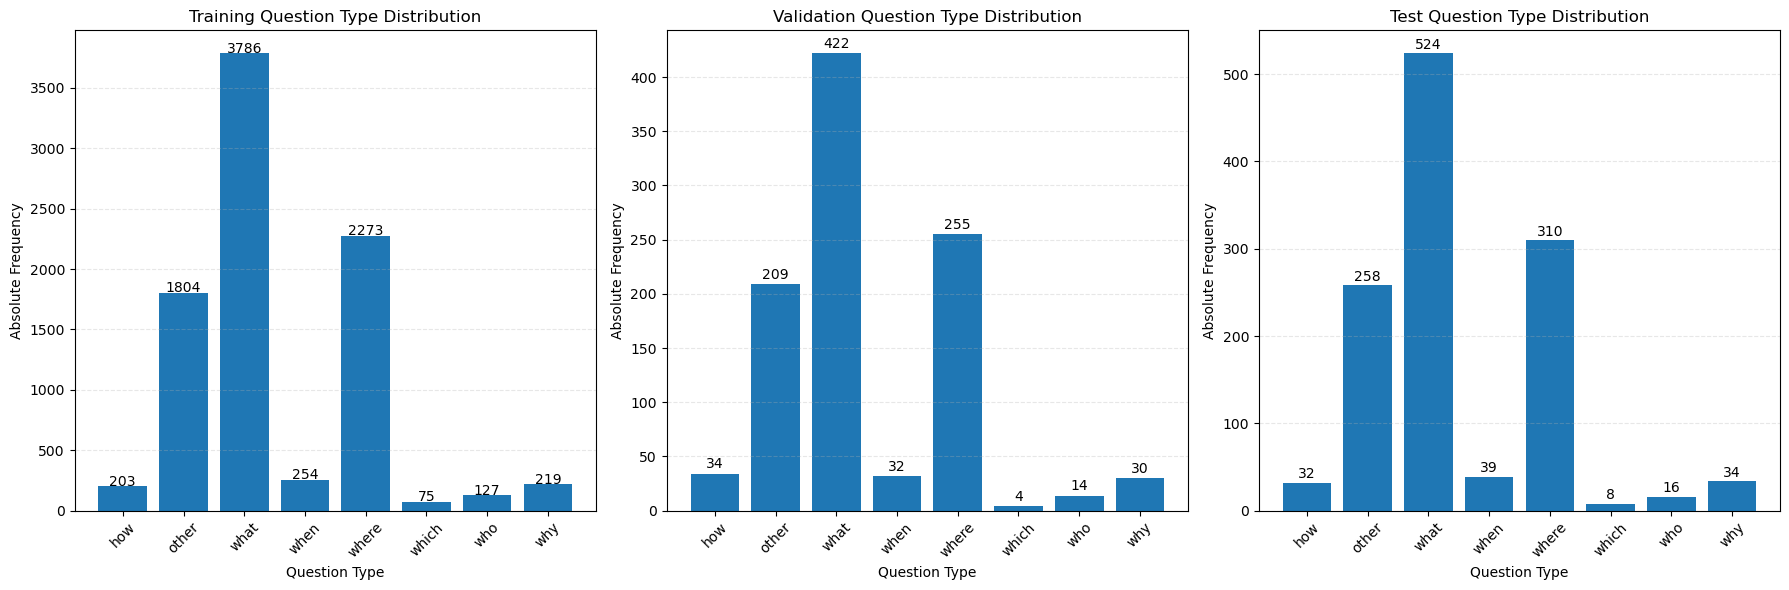

In [13]:
plt.figure(figsize=(18, 6))

for split, df in datasets.items():
    print(f"Columns in {split} dataset:", df.columns.tolist())

for i, (split, df) in enumerate(datasets.items(), 1):

    question_type_counts = Counter(df['question_type'])

    sorted_types = sorted(question_type_counts.keys())
    sorted_counts = [question_type_counts[t] for t in sorted_types]

    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_counts)
    plt.xlabel("Question Type")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Question Type Distribution")

    for j, (q_type, count) in enumerate(zip(sorted_types, sorted_counts)):
        plt.text(j, count + 5, str(count), ha='center')
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('viz/question_type_distribution.png', dpi=300)
plt.show()

Count question types and convert it to percentage

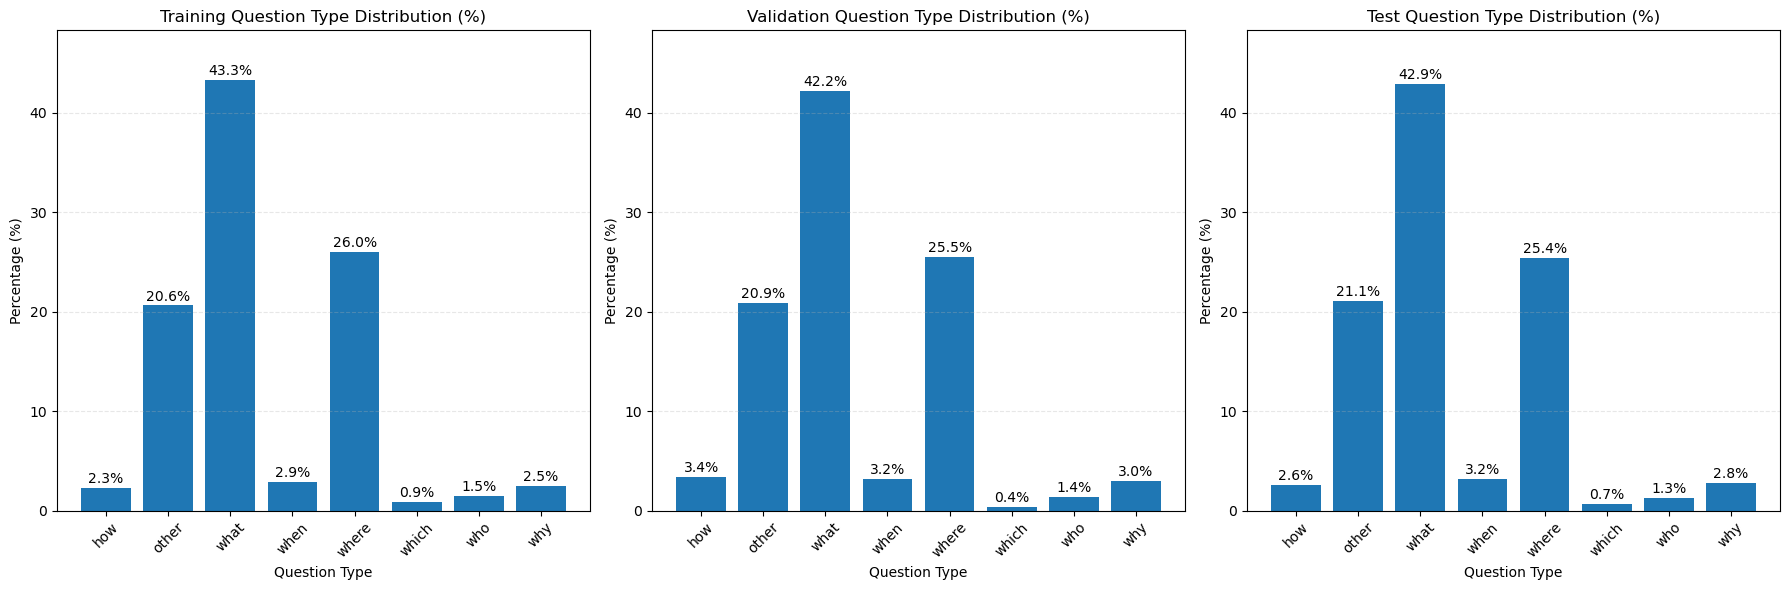

In [14]:
plt.figure(figsize=(18, 6))

train_type_counts = Counter(train_df['question_type'])
valid_type_counts = Counter(valid_df['question_type'])
test_type_counts = Counter(test_df['question_type'])

train_type_percent = {k: v/len(train_df)*100 for k, v in train_type_counts.items()}
valid_type_percent = {k: v/len(valid_df)*100 for k, v in valid_type_counts.items()}
test_type_percent = {k: v/len(test_df)*100 for k, v in test_type_counts.items()}

datasets = {
    "Training": train_type_percent,
    "Validation": valid_type_percent,
    "Test": test_type_percent
}


for i, (split, percent_dict) in enumerate(datasets.items(), 1):

    sorted_types = sorted(percent_dict.keys())
    sorted_percents = [percent_dict[t] for t in sorted_types]
    
    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_percents)
    plt.xlabel("Question Type")
    plt.ylabel("Percentage (%)")
    plt.title(f"{split} Question Type Distribution (%)")
    
    for j, (q_type, percent) in enumerate(zip(sorted_types, sorted_percents)):
        plt.text(j, percent + 0.5, f"{percent:.1f}%", ha='center')
    

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.ylim(0, max(max(train_type_percent.values()), 
                   max(valid_type_percent.values()),
                   max(test_type_percent.values())) + 5)

plt.tight_layout()
plt.savefig('viz/question_type_percentage_distribution.png', dpi=300)
plt.show()

POS (Part-of-Speach) Tag analysis for questions

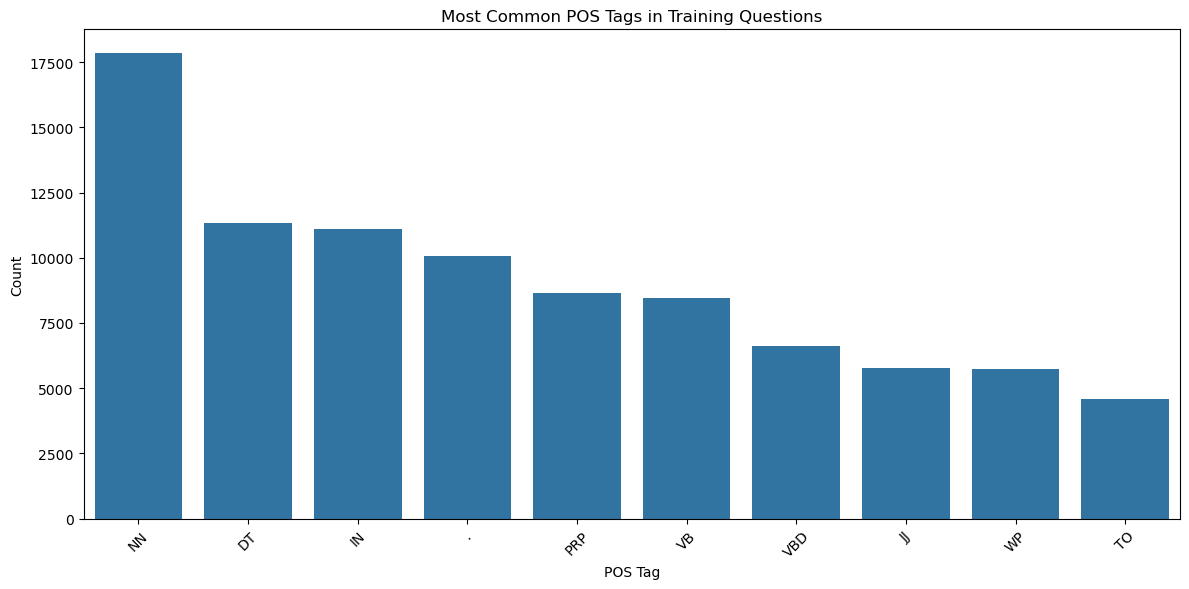

In [15]:
def analyze_pos_tags(texts, n=10):
    """Analyze the most common POS tags in a list of texts"""
    all_pos = []
    for text in texts:
        tokens = word_tokenize(text)
        tags = pos_tag(tokens)
        all_pos.extend([tag for _, tag in tags])
    
    return Counter(all_pos).most_common(n)

train_pos = analyze_pos_tags(train_df['question'].tolist())

plt.figure(figsize=(12, 6))
pos_df = pd.DataFrame(train_pos, columns=['POS Tag', 'Count'])
sns.barplot(x='POS Tag', y='Count', data=pos_df)
plt.title('Most Common POS Tags in Training Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('viz/pos_tag_distribution.png')
plt.show()
plt.close()

Analyze vocabulary overlap between train and test

In [16]:
def get_vocab(texts):
    """Get vocabulary from a list of texts"""
    vocab = set()
    for text in texts:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
    return vocab

train_vocab = get_vocab(train_df['question'].tolist())
test_vocab = get_vocab(test_df['question'].tolist())

Calculate overlap and plot venn diagramm

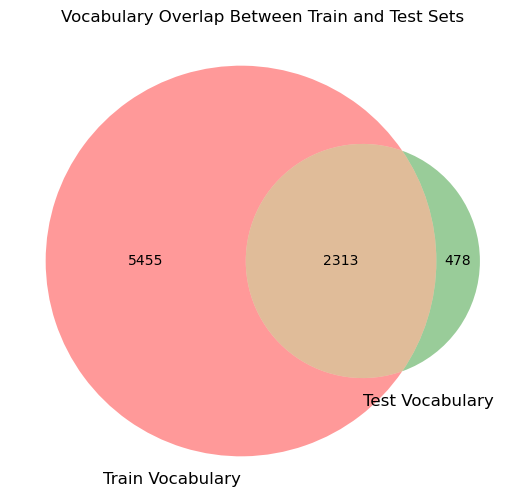

Train vocabulary size: 7768
Test vocabulary size: 2791
Vocabulary overlap: 2313 words (29.78% of train vocab)


In [17]:
overlap = len(train_vocab.intersection(test_vocab))
train_only = len(train_vocab - test_vocab)
test_only = len(test_vocab - train_vocab)

plt.figure(figsize=(10, 6))

venn2(subsets=(train_only, test_only, overlap), 
      set_labels=('Train Vocabulary', 'Test Vocabulary'))
plt.title('Vocabulary Overlap Between Train and Test Sets')
plt.savefig('viz/vocab_overlap.png')
plt.show()
plt.close()

print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")
print(f"Vocabulary overlap: {overlap} words ({overlap/len(train_vocab)*100:.2f}% of train vocab)")

# Preprocessing

As per the project requirements we need correct and justified decisions on: 
- Tokenization 
- Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
- Removal of unknown/other words 
- Format cleaning (e.g. html-extracted text) 
- Truncation 
- Feature selection 
- Input format: how is data passed to the model? 
- Label format: what should the model predict? 
- Batching, padding 
- Vocabulary, embedding

We choose minimal preprocessing:
- We tokenize using NLTK's word tokenizer
- We preserve case, stopwords, and punctuation as they contain valuable information
- We skip stemming/lemmatization since our model (fasttext) handles word variations effectively
- No unknown word removal needed as fasttext creates vectors from character substrings
- No truncation required since all questions are under 400 characters
- No format cleaning needed as the dataset is already clean

To mention some examples, my preprocess function just performs simple tokenization preserving case, punctuation and all words including stopwords. I choose this approach because:
  - Case preservation: Words like 'I' or 'US' retain their semantic meaning
  - Stopword retention: Function words provide grammatical context important for question answering
  - Punctuation preservation: Punctuation can carry meaningful information
  - No stemming/lemmatization: Fasttext can handle morphological variations through subword embeddings
  - No unknown word removal: Fasttext creates vectors from character n-grams, allowing it to handle OOV words and misspellings

In [18]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string, got {0} instead".format(type(text).__name__))
    
    if not text or text.isspace():
        raise ValueError("Input text cannot be empty or whitespace only")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt')
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK punkt tokenizer: {str(e)}")

    try:
        tokens = word_tokenize(text)
        
        if len(tokens) == 0 and len(text.strip()) > 0:
            raise RuntimeError("Tokenization produced no tokens for non-empty input")
            
        return tokens
        
    except Exception as e:
        raise RuntimeError(f"Tokenization failed: {str(e)}")

To get a better understanding we check how the loaded embeddings look and how big the vocabulary is.

In [19]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print("\nFirst 10 words in vocabulary:")
print(wv.index_to_key[:10])

print("\nLast 5 words in vocabulary:")
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000

First 10 words in vocabulary:
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']

Last 5 words in vocabulary:
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Further we analyse how the vectors of different words look like

In [20]:
#print vector of word that should exist
print(wv["if"])

#print vector of word that should not exist
print(wv["apdnbajknbäaperoanböajnbäpad"])

[ 7.05022831e-03 -2.72363335e-01  3.08294799e-02 -6.69213533e-02
 -2.38569006e-01 -6.97940290e-02 -1.78919464e-01 -1.30932003e-01
  1.95379898e-01 -1.02779709e-01  1.13138333e-01 -8.10120851e-02
 -2.31069531e-02  8.10398385e-02  4.11642976e-02  2.13612169e-01
  2.07227275e-01 -1.44993244e-02 -1.49006667e-02  3.30467045e-01
 -8.75898227e-02  2.77748536e-02  1.65837809e-01 -2.82677233e-01
 -2.31202438e-01 -6.97928965e-02 -9.50594172e-02  1.27312019e-01
  8.41282010e-02  3.78092974e-01  8.13675299e-02 -4.12413254e-02
  3.80182602e-02 -8.93339440e-02 -6.99183196e-02  1.94707839e-03
  2.10201159e-01 -1.43054217e-01 -5.38324825e-02  5.93089908e-02
 -3.86625379e-02  6.96267113e-02 -2.00814441e-01  5.09383306e-02
  1.98449627e-01 -3.92922424e-02  5.64378798e-02  3.31560552e-01
  7.08746612e-02 -3.91262211e-02 -8.44963491e-02 -3.65556516e-02
  9.49307606e-02 -2.95668654e-02 -7.00519904e-02 -2.10410550e-01
 -1.39795244e-01  1.62995517e-01 -1.53789535e-01 -8.67058709e-02
 -7.03049498e-03 -2.27405

## Torch Dataloader and Dataset

## PyTorch Dataset and DataLoader with TF-IDF Weighting

For my CommonsenseQA model, I've created a custom PyTorch dataset that converts text into tensor representations using TF-IDF weighting. My dataset returns:

1. **Question Tensor**: Shape `(embedding_dim)` encoding the question semantics
2. **Choices Tensor**: Shape `(5, embedding_dim)` containing embeddings for each answer option
3. **Answer Index**: A tensor with the correct answer's index (0-4), converted from "A"-"E"

### TF-IDF Enhanced Embeddings

I've improved standard word averaging by using TF-IDF weighting which:
1. Gives higher importance to informative, distinctive words
2. Reduces the influence of common words
3. Creates more semantically meaningful representations

My implementation includes dual-level caching (in-memory LRU and disk persistence) for efficient processing of the large dataset while maintaining reasonable memory usage.

In [21]:
class CommonsenseQAEmbeddingDataset(Dataset):
    """Dataset for CommonsenseQA with TF-IDF weighted embeddings and caching capabilities"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300, cache_path=None, use_tfidf=True):
        self.data = hf_dataset
        self.wv = word_vectors
        
        # Set embedding dimension directly or derive it from a vector
        if embedding_dim is not None:
            self.embedding_dim = embedding_dim
        else:
            # Try to infer embedding dimension from a sample vector
            # For a dictionary-like structure
            if isinstance(word_vectors, dict):
                sample_word = next(iter(word_vectors))
                self.embedding_dim = len(word_vectors[sample_word])
            # For direct numpy arrays
            elif hasattr(word_vectors, 'shape') and len(word_vectors.shape) == 2:
                self.embedding_dim = word_vectors.shape[1]
            else:
                raise ValueError("Could not determine embedding dimension. Please provide embedding_dim parameter.")
        
        self.cache = {}
        self.use_tfidf = use_tfidf
        self.idf_scores = {}
        
        # Load cache if provided and exists
        if cache_path and os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    self.cache = pickle.load(f)
                print(f"Loaded {len(self.cache)} cached embeddings")
            except Exception as e:
                print(f"Failed to load cache: {e}")
                self.cache = {}
        
        # Configure cache_path for saving if provided
        self.cache_path = cache_path
        
        # Calculate IDF scores if using TF-IDF
        if use_tfidf:
            self._calculate_idf_scores()
    
    def __len__(self):
        return len(self.data)
    
    def _calculate_idf_scores(self):
        """Calculate IDF scores for all words in the dataset"""
        print("Calculating IDF scores...")
        
        # Collect all texts
        all_texts = []
        for example in tqdm(self.data, desc="Collecting texts"):
            all_texts.append(example["question"])
            all_texts.extend(example["choices"]["text"])
        
        # Create document-term matrix
        doc_term_counts = defaultdict(Counter)
        doc_count = len(all_texts)
        
        for doc_id, text in enumerate(tqdm(all_texts, desc="Counting terms")):
            tokens = preprocess_text(text)
            # Count each token only once per document
            for token in set(tokens):
                if token in self.wv:
                    doc_term_counts[token][doc_id] += 1
        
        # Calculate IDF scores: log(N/df) where N is total docs and df is doc frequency
        self.idf_scores = {
            term: np.log(doc_count / (len(doc_ids) + 1))
            for term, doc_ids in doc_term_counts.items()
        }
        
        print(f"Calculated IDF scores for {len(self.idf_scores)} terms")
    
    @functools.lru_cache(maxsize=1024)
    def get_embedding(self, text):
        """Get embedding for text with TF-IDF weighting and caching for efficiency"""
        # Check if already in cache
        if text in self.cache:
            return self.cache[text]
        
        # If not in cache, compute embedding
        try:
            tokens = preprocess_text(text)
            # Filter tokens to only those in vocabulary
            valid_tokens = [word for word in tokens if word in self.wv]
            
            if not valid_tokens:
                # Return zeros if no valid tokens
                embedding = np.zeros(self.embedding_dim)
            else:
                if self.use_tfidf:
                    # Calculate term frequencies for this text
                    term_counts = Counter(valid_tokens)
                    # Get TF-IDF weights
                    weights = np.array([
                        term_counts[term] * self.idf_scores.get(term, 0.0) 
                        for term in valid_tokens
                    ])
                    # Normalize weights to prevent numerical issues
                    sum_weights = weights.sum()
                    if sum_weights > 0:
                        weights = weights / sum_weights
                    
                    # Calculate weighted average of word vectors
                    word_vectors = np.array([self.wv[word] for word in valid_tokens])
                    embedding = np.sum(word_vectors * weights[:, np.newaxis], axis=0)
                else:
                    # Use simple mean if not using TF-IDF
                    word_vectors = [self.wv[word] for word in valid_tokens]
                    embedding = np.mean(word_vectors, axis=0)
            
            # Store in cache
            self.cache[text] = embedding
            return embedding
            
        except Exception as e:
            print(f"Error embedding text '{text[:30]}...': {e}")
            # Return zeros on error
            return np.zeros(self.embedding_dim)

    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Get question embedding
        question_embedding = self.get_embedding(example["question"])
        
        # Get choice embeddings
        choice_embeddings = [self.get_embedding(choice) for choice in example["choices"]["text"]]
        
        # Convert answer key to index (A->0, B->1, etc.)
        answer_index = ord(example["answerKey"]) - ord("A")
        
        # Convert to PyTorch tensors
        question_tensor = torch.tensor(question_embedding).float()
        choices_tensor = torch.tensor(choice_embeddings).float()
        answer_tensor = torch.tensor(answer_index).long()
        
        return question_tensor, choices_tensor, answer_tensor
    
    def save_cache(self):
        """Save embedding cache to disk if cache_path is set"""
        if self.cache_path:
            with open(self.cache_path, 'wb') as f:
                pickle.dump(self.cache, f)
            print(f"Saved {len(self.cache)} embeddings to cache")

In [22]:
class NormalizedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # L2 normalize question embedding
        question_norm = torch.norm(question, p=2)
        if question_norm > 0:
            question = question / question_norm
        
        # L2 normalize each choice embedding
        normalized_choices = choices.clone()
        for i in range(choices.size(0)):
            choice_norm = torch.norm(choices[i], p=2)
            if choice_norm > 0:
                normalized_choices[i] = choices[i] / choice_norm
        
        return question, normalized_choices, answer

### Creating Dataset and DataLoader Instances

I initialize my dataset objects with TF-IDF weighting enabled for both training and validation sets. Each dataset uses disk-based caching to preserve computed embeddings between runs.

For efficient batch processing during training, I configure DataLoaders with:

- Batch size of 128 examples
- Shuffling enabled for training (disabled for validation)
- 4 worker processes for parallel data loading
- GPU memory pinning for faster data transfer

In [23]:
import random

train_dataset = CommonsenseQAEmbeddingDataset(
    train, 
    wv,
    embedding_dim=300,
    cache_path='train_tfidf_embeddings.pkl',
    use_tfidf=False
)

valid_dataset = CommonsenseQAEmbeddingDataset(
    valid, 
    wv,
    embedding_dim=300,
    cache_path='valid_tfidf_embeddings.pkl',
    use_tfidf=False
)

class AugmentedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, noise_scale=0.01):
        self.base_dataset = base_dataset
        self.noise_scale = noise_scale
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # Add small Gaussian noise (20% of the time)
        if random.random() < 0.2:
            question = question + torch.randn_like(question) * self.noise_scale
            choices = choices + torch.randn_like(choices) * self.noise_scale
        
        return question, choices, answer

normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)

# Wrap your training dataset with augmentation
augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)

# Create DataLoaders with appropriate batch sizes
train_loader = DataLoader(
    augmented_train_dataset,
    batch_size=512,  # Smaller batch size
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    normalized_valid_dataset,
    batch_size=1024,  # Can be larger for validation
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## RNN

In [24]:
class CommonsenseQARNNDataset(Dataset):
    """Dataset for CommonsenseQA with RNN processing capabilities"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300, max_seq_length=50, cache_path=None):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
        self.max_seq_length = max_seq_length
        self.cache = {}
        
        # Special tokens
        self.PAD_TOKEN = "<PAD>"
        self.UNK_TOKEN = "<UNK>"
        self.SEP_TOKEN = "<SEP>"
        
        # Load cache if provided and exists
        if cache_path and os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    cache_data = pickle.load(f)
                    self.cache = cache_data.get('sequences', {})
                    self.word_to_idx = cache_data.get('vocab', {})
                    if not self.word_to_idx:
                        self.word_to_idx = self._build_vocab()
                print(f"Loaded {len(self.cache)} cached sequences")
            except Exception as e:
                print(f"Failed to load cache: {e}")
                self.cache = {}
                self.word_to_idx = self._build_vocab()
        else:
            # Build vocabulary
            self.word_to_idx = self._build_vocab()
        
        # Configure cache_path for saving if provided
        self.cache_path = cache_path
        print(f"Built vocabulary with {len(self.word_to_idx)} words")
    
    def _build_vocab(self):
        """Build a simplified vocabulary with special tokens and common words"""
        word_to_idx = {
            self.PAD_TOKEN: 0,
            self.UNK_TOKEN: 1,
            self.SEP_TOKEN: 2
        }
        
        # Get words directly from dataset to ensure vocabulary coverage
        print("Building vocabulary from dataset...")
        all_words = set()
        
        # Sample from dataset to build vocabulary
        for idx in tqdm(range(len(self.data))):
            example = self.data[idx]
            
            # Add question words
            question_tokens = preprocess_text(example["question"])
            all_words.update(question_tokens)
            
            # Add choice words
            for choice in example["choices"]["text"]:
                choice_tokens = preprocess_text(choice)
                all_words.update(choice_tokens)
            
            # Limit vocabulary size for efficiency
            if len(all_words) > 50000:
                break
        
        # Add words to vocabulary
        idx = 3
        for word in all_words:
            if word not in word_to_idx and word in self.wv:
                word_to_idx[word] = idx
                idx += 1
        
        print(f"Created vocabulary with {len(word_to_idx)} words")
        return word_to_idx
    
    def __len__(self):
        return len(self.data)
    
    def _get_word_idx(self, word):
        """Get vocabulary index for a word, using UNK for OOV words"""
        return self.word_to_idx.get(word, self.word_to_idx[self.UNK_TOKEN])
    
    def prepare_sequence(self, question, choice):
        """Tokenize and prepare a question-choice sequence"""
        # Create cache key
        cache_key = f"{question}:{choice}"
        
        # Check if already in cache
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        # Tokenize using your existing preprocess_text function
        question_tokens = preprocess_text(question)
        choice_tokens = preprocess_text(choice)
        
        # Combine question and choice with separator
        combined_tokens = question_tokens + [self.SEP_TOKEN] + choice_tokens
        
        # Truncate if too long
        if len(combined_tokens) > self.max_seq_length:
            combined_tokens = combined_tokens[:self.max_seq_length]
        
        # Convert to vocabulary indices
        token_ids = [self._get_word_idx(token) for token in combined_tokens]
        
        # Store in cache
        self.cache[cache_key] = token_ids
        
        return token_ids
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Get question
        question = example["question"]
        
        # Get choices
        choices = example["choices"]["text"]
        
        # Prepare sequences for each question-choice pair
        sequences = []
        sequence_lengths = []
        
        for choice in choices:
            seq = self.prepare_sequence(question, choice)
            sequences.append(torch.tensor(seq, dtype=torch.long))
            sequence_lengths.append(len(seq))
        
        # Convert answer key to index (A->0, B->1, etc.)
        answer_index = ord(example["answerKey"]) - ord("A")
        answer = torch.tensor(answer_index, dtype=torch.long)
        
        return sequences, sequence_lengths, answer
    
    def save_cache(self):
        """Save sequences cache and vocabulary to disk if cache_path is set"""
        if self.cache_path:
            cache_data = {
                'sequences': self.cache,
                'vocab': self.word_to_idx
            }
            with open(self.cache_path, 'wb') as f:
                pickle.dump(cache_data, f)
            print(f"Saved {len(self.cache)} sequences with vocabulary of {len(self.word_to_idx)} words to cache")
    
    def get_embedding_matrix(self):
        """Create an embedding matrix for initializing the embedding layer"""
        vocab_size = len(self.word_to_idx)
        embedding_matrix = torch.zeros(vocab_size, self.embedding_dim)
        
        # Fill known words with pretrained vectors
        for word, idx in self.word_to_idx.items():
            if word == self.PAD_TOKEN:
                # Zero vector for padding
                pass
            elif word == self.UNK_TOKEN or word == self.SEP_TOKEN:
                # Random initialization for special tokens
                embedding_matrix[idx] = torch.randn(self.embedding_dim) * 0.1
            else:
                try:
                    # Get vector from word vectors
                    embedding_matrix[idx] = torch.tensor(self.wv[word])
                except (KeyError, ValueError):
                    # If word isn't found, use random initialization
                    embedding_matrix[idx] = torch.randn(self.embedding_dim) * 0.1
                
        return embedding_matrix

In [25]:
def collate_rnn_batch(batch):
    """Collate function for RNN batches"""
    # Unpack batch
    all_sequences = []
    all_lengths = []
    all_answers = []
    
    for sequences, lengths, answer in batch:
        all_sequences.append(sequences)
        all_lengths.append(lengths)
        all_answers.append(answer)
    
    # Stack answers
    answers_tensor = torch.stack(all_answers)
    
    return all_sequences, all_lengths, answers_tensor

In [26]:
train_rnn_dataset = CommonsenseQARNNDataset(
    train, 
    wv,
    embedding_dim=300,
    max_seq_length=50,
    cache_path='train_rnn_cache.pkl'
)

valid_rnn_dataset = CommonsenseQARNNDataset(
    valid, 
    wv,
    embedding_dim=300,
    max_seq_length=50,
    cache_path='valid_rnn_cache.pkl'
)

# Check dataset sample
sample_idx = 0
sequences, lengths, answer = train_rnn_dataset[sample_idx]
print(f"Sample question has {len(sequences)} choices")
for i, (seq, length) in enumerate(zip(sequences, lengths)):
    print(f"Choice {i+1}: {length} tokens")
print(f"Correct answer: {answer.item()}")


Building vocabulary from dataset...


100%|██████████| 8741/8741 [00:05<00:00, 1708.43it/s]


Created vocabulary with 12018 words
Built vocabulary with 12018 words
Building vocabulary from dataset...


100%|██████████| 1000/1000 [00:00<00:00, 4105.61it/s]

Created vocabulary with 4349 words
Built vocabulary with 4349 words
Sample question has 5 choices
Choice 1: 26 tokens
Choice 2: 26 tokens
Choice 3: 26 tokens
Choice 4: 27 tokens
Choice 5: 26 tokens
Correct answer: 0


In [27]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=32,  # Smaller batch size for this approach
    shuffle=True,
    collate_fn=collate_rnn_batch,
    num_workers=2,
    pin_memory=True
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=32,  # Smaller batch size for this approach
    shuffle=False,
    collate_fn=collate_rnn_batch,
    num_workers=2,
    pin_memory=True
)

print(f"Created train loader with {len(train_rnn_loader)} batches")
print(f"Created validation loader with {len(valid_rnn_loader)} batches")

Created train loader with 274 batches
Created validation loader with 32 batches


# Model

## Embedding Model with Attention for CommonsenseQA

I've implemented a QA classifier model that uses an attention mechanism to better capture the relationship between questions and answer choices.

My model architecture takes the following approach:

1. I first project questions and choices into a common hidden space using separate linear layers
2. I implement an attention mechanism that helps the model focus on relevant parts of each choice based on the question
3. I include multiple regularization techniques like dropout and layer normalization to prevent overfitting
4. I use concatenation of question and choice representations after they've been properly aligned in the same semantic space

The model processes inputs by:
1. Projecting the question embedding into a hidden representation
2. Projecting each of the five choice embeddings into the same hidden space
3. Computing attention weights between the question and each choice
4. Applying these weights to emphasize important aspects of the choices
5. Concatenating question and weighted choice representations
6. Making the final prediction through fully-connected layers

I've chosen to use AdamW as my optimizer with a learning rate scheduler to automatically adjust the learning rate during training. This combination helps the model converge to better solutions more efficiently.

For the activation functions, I use ReLU in the projection layers and LeakyReLU in the classification layers to help with smoother gradient flow throughout the network.

In [28]:
class QASimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256, dropout_rate=0.2):
        super(QASimpleClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Improved projection layers with intermediate sizes
        self.question_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.choice_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Maintain 2-layer architecture with better feature interaction
        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.bn_fc1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Moderate dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()
        
        # Initialize with better scale
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, question, choices):
        batch_size, num_choices, _ = choices.size()
        
        # Process question
        projected_question = self.question_projection[0](question)  # Linear
        projected_question = self.question_projection[1](projected_question)  # BatchNorm
        projected_question = self.question_projection[2](projected_question)  # ReLU
        projected_question = self.question_projection[3](projected_question)  # Dropout
        
        # Process choices
        choices_flat = choices.view(batch_size * num_choices, -1)
        projected_choices = self.choice_projection[0](choices_flat)  # Linear
        projected_choices = self.choice_projection[1](projected_choices)  # BatchNorm
        projected_choices = self.choice_projection[2](projected_choices)  # ReLU
        projected_choices = self.choice_projection[3](projected_choices)  # Dropout
        
        # Reshape choices back
        projected_choices = projected_choices.view(batch_size, num_choices, -1)
        
        # Expand question to match choices dimension
        question_expanded = projected_question.unsqueeze(1).expand(-1, num_choices, -1)
        
        # Concatenate
        combined = torch.cat((question_expanded, projected_choices), dim=2)
        
        # First layer
        x = self.fc1(combined)
        x_flat = x.view(batch_size * num_choices, -1)
        x_flat = self.bn_fc1(x_flat)
        x_flat = self.activation(x_flat)
        x_flat = self.dropout(x_flat)
        x = x_flat.view(batch_size, num_choices, -1)
        
        # Output layer
        x = self.fc2(x)
        
        return x.squeeze(-1)

In [29]:
# Instantiate the model with improved parameters
embedding_dim = 300
hidden_dim = 64  # Start with a reasonable size
dropout_rate = 0.2  # Moderate dropout

# Create model
qa_model = QASimpleClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
qa_model = qa_model.to(device)

print(qa_model)

Using device: cuda
QASimpleClassifier(
  (question_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (choice_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)


## RNN

In [30]:
class QARNNModel(nn.Module):
    """RNN model for CommonsenseQA with 2-layer LSTM and 2-layer classifier"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate=0.3):
        super(QARNNModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 2-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,  # Fixed as per requirement
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # 2-layer classifier with ReLU activation
        lstm_output_dim = hidden_dim * 2  # bidirectional = *2
        self.fc1 = nn.Linear(lstm_output_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def process_sequence(self, sequence):
        """Process a single sequence (no batch dimension)"""
        # Handle empty sequences
        if sequence.numel() == 0:
            return torch.zeros(1, device=sequence.device)
        
        # Add batch dimension of 1
        sequence = sequence.unsqueeze(0)
    
        # Embed the sequence
        embedded = self.embedding(sequence)
    
        # Process through LSTM (we don't need to pack since it's a single sequence)
        try:
            _, (hidden, _) = self.lstm(embedded)
        
            # Get final hidden state from both directions
            # Check dimensions to avoid concatenation errors
            if hidden.dim() == 3 and hidden.size(1) > 0:
                # Normal case - concatenate the forward and backward directions
                final_hidden = torch.cat([hidden[-2, 0], hidden[-1, 0]], dim=0)
            else:
                # Handle edge case - create a zero vector of appropriate size
                final_hidden = torch.zeros(self.hidden_dim * 2, device=sequence.device)
        except Exception as e:
            # Fallback for any LSTM errors - use a zero vector
            print(f"Error in LSTM processing: {e}")
            final_hidden = torch.zeros(self.hidden_dim * 2, device=sequence.device)
    
        # First layer of classifier
        x = self.fc1(final_hidden)
        x = self.relu(x)
        x = self.dropout(x)
    
        # Second layer to output
        logit = self.fc2(x)
    
        return logit
    
    def forward(self, batch_sequences, batch_lengths):
        """
        Process batch by processing each example separately
    
        Args:
            batch_sequences: List of lists of tensor sequences
            batch_lengths: List of lists of sequence lengths
    
        Returns:
            Tensor of logits [batch_size, num_choices]
        """
        batch_size = len(batch_sequences)
        num_choices = len(batch_sequences[0])
    
        # Store results
        all_logits = []
    
        # Process each example in the batch
        for i in range(batch_size):
            example_sequences = batch_sequences[i]
            example_logits = []
        
            # Process each choice for this example
            for j in range(num_choices):
                sequence = example_sequences[j].to(device)  # Move to device here
            
                # Ensure sequence is long tensor (fix for the error)
                if sequence.dtype != torch.long:
                    sequence = sequence.long()
                
                logit = self.process_sequence(sequence)
                example_logits.append(logit)
        
            # Combine logits for all choices for this example
            example_logits = torch.cat(example_logits)
            all_logits.append(example_logits)
    
        # Stack all example logits into a batch
        logits_tensor = torch.stack(all_logits)
    
        return logits_tensor

# Training

Initialize Weights & Biases experiment tracking

In [31]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nevin-helfenstein (nevinhelfenstein-hslu-nlp-fs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [32]:
embedding_run = wandb.init(
  project="hslu-fs25-nlp-embedding-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"optimized-qa-classifier-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_simple_classifier",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 256,  # Smaller batch size
    "epochs": 60,
    "dropout_rate": dropout_rate,
    "weight_decay": 1e-5,  # Very light weight decay
    "label_smoothing": 0.0,  # No label smoothing initially
    "gradient_clipping": 1.0,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [33]:
wandb.watch(qa_model, log="all")

## Training the QA Model with Attention

For training my CommonsenseQA model, I've implemented a comprehensive training pipeline with performance tracking and checkpoint saving. My approach focuses on optimizing learning rate dynamics and preventing overfitting through appropriate regularization.

### Setting Up Training Components
I first define the loss function, optimizer, and learning rate scheduler:


In [34]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Use Adam with slightly higher initial learning rate
optimizer = torch.optim.Adam(
    qa_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=50,      # First restart after 50 epochs
    T_mult=2,    # Double period after each restart
    eta_min=1e-5 # Minimum LR
)

I chose AdamW as my optimizer because it performs well with its integrated weight decay mechanism. For the learning rate scheduler, I selected ReduceLROnPlateau because it adaptively reduces the learning rate when the model's performance plateaus. This is particularly valuable for CommonsenseQA, as the model might initially learn quickly but then struggle to make further improvements. 

**Checkpoint Management**

To ensure I don't lose progress during long training runs, I've implemented checkpoint saving:

In [35]:
checkpoints_path  = "./checkpoints/qa_model"
os.makedirs(checkpoints_path, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, scheduler, path, name, val_accuracy=None):
    """Save model checkpoint with additional metadata"""
    checkpoint_path = os.path.join(path, f"{name}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "val_accuracy": val_accuracy,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

**Training Loop Implementation**

My training function tracks both training and validation metrics for each epoch. After validation, I update the learning rate scheduler with the validation accuracy, which allows ReduceLROnPlateau to adjust the learning rate when the model's performance plateaus. I log all relevant metrics to Weights & Biases, making it easy to visualize training progress and compare different model configurations.

In [36]:
def train_qa_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, 
                  log_wandb=True, gradient_clip_val=1.0):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for question_batch, choices_batch, answer_batch in progress_bar:
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answer_batch.size(0)
                train_correct += (predicted == answer_batch).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answer_batch.size(0)
                val_correct += (predicted == answer_batch).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, 
                          checkpoints_path, "best_model", val_accuracy)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [37]:
def check_model_and_data():
    print("Performing basic checks...")
    
    # 1. Check if the dataset has balanced classes
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_dataset))):  # Check a subsample
        _, _, answer = train_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Check if embeddings have reasonable norms
    embedding_norms = []
    for i in range(10):  # Check first 10 samples
        question, choices, _ = train_dataset[i]
        embedding_norms.append(torch.norm(question).item())
    
    print(f"Average question embedding norm: {np.mean(embedding_norms):.4f}")
    
    # 3. Do a single forward pass to check output shape
    model = qa_model.to(device)
    model.eval()
    with torch.no_grad():
        question, choices, _ = train_dataset[0]
        question = question.unsqueeze(0).to(device)  # Add batch dimension
        choices = choices.unsqueeze(0).to(device)  # Add batch dimension
        
        output = model(question, choices)
        print(f"Model output shape: {output.shape}")
        print(f"Sample logits: {output[0]}")
    
    print("Checks complete.")

# Run the checks
check_model_and_data()

Performing basic checks...


/tmp/ipykernel_51911/3859152948.py:136: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  choices_tensor = torch.tensor(choice_embeddings).float()


Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Average question embedding norm: 0.9680
Model output shape: torch.Size([1, 5])
Sample logits: tensor([-0.1141, -0.0870, -0.0926, -0.3318, -0.1333], device='cuda:0')
Checks complete.


In [38]:
print("Starting training...")
num_epochs = embedding_run.config.epochs
trained_model, best_accuracy = train_qa_model(
    qa_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    num_epochs,
    gradient_clip_val=embedding_run.config.gradient_clipping
)

print(f"Training complete! Best validation accuracy: {best_accuracy:.4f}")

Starting training...

Epoch 1/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Validation accuracy improved from 0.0000 to 0.1920
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.7747, Train Acc: 0.2048
Val Loss: 1.6116, Val Acc: 0.1920

Epoch 2/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Validation accuracy improved from 0.1920 to 0.1970
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.7121, Train Acc: 0.2186
Val Loss: 1.6156, Val Acc: 0.1970

Epoch 3/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Validation accuracy improved from 0.1970 to 0.2080
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6947, Train Acc: 0.2162
Val Loss: 1.6225, Val Acc: 0.2080

Epoch 4/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.6735, Train Acc: 0.2201
Val Loss: 1.6264, Val Acc: 0.1940

Epoch 5/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.6519, Train Acc: 0.2337
Val Loss: 1.6270, Val Acc: 0.2030

Epoch 6/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Train Loss: 1.6392, Train Acc: 0.2385
Val Loss: 1.6245, Val Acc: 0.2040

Epoch 7/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.6362, Train Acc: 0.2352
Val Loss: 1.6234, Val Acc: 0.2060

Epoch 8/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.6297, Train Acc: 0.2409
Val Loss: 1.6228, Val Acc: 0.2000

Epoch 9/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.6242, Train Acc: 0.2440
Val Loss: 1.6194, Val Acc: 0.2030

Epoch 10/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Validation accuracy improved from 0.2080 to 0.2140
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6036, Train Acc: 0.2571
Val Loss: 1.6161, Val Acc: 0.2140

Epoch 11/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.5974, Train Acc: 0.2543
Val Loss: 1.6140, Val Acc: 0.2110

Epoch 12/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Train Loss: 1.5950, Train Acc: 0.2624
Val Loss: 1.6118, Val Acc: 0.2110

Epoch 13/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Train Loss: 1.5819, Train Acc: 0.2668
Val Loss: 1.6099, Val Acc: 0.2120

Epoch 14/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Validation accuracy improved from 0.2140 to 0.2220
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5832, Train Acc: 0.2676
Val Loss: 1.6096, Val Acc: 0.2220

Epoch 15/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5663, Train Acc: 0.2737
Val Loss: 1.6094, Val Acc: 0.2160

Epoch 16/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5687, Train Acc: 0.2771
Val Loss: 1.6091, Val Acc: 0.2090

Epoch 17/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Train Loss: 1.5634, Train Acc: 0.2801
Val Loss: 1.6086, Val Acc: 0.2150

Epoch 18/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Train Loss: 1.5692, Train Acc: 0.2785
Val Loss: 1.6085, Val Acc: 0.2140

Epoch 19/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5664, Train Acc: 0.2786
Val Loss: 1.6087, Val Acc: 0.2140

Epoch 20/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5673, Train Acc: 0.2773
Val Loss: 1.6068, Val Acc: 0.2180

Epoch 21/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Validation accuracy improved from 0.2220 to 0.2360
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5593, Train Acc: 0.2815
Val Loss: 1.6011, Val Acc: 0.2360

Epoch 22/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5543, Train Acc: 0.2913
Val Loss: 1.6003, Val Acc: 0.2250

Epoch 23/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5492, Train Acc: 0.2928
Val Loss: 1.6027, Val Acc: 0.2160

Epoch 24/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5429, Train Acc: 0.3026
Val Loss: 1.6024, Val Acc: 0.2140

Epoch 25/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.5384, Train Acc: 0.3028
Val Loss: 1.6009, Val Acc: 0.2210

Epoch 26/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5347, Train Acc: 0.3099
Val Loss: 1.6011, Val Acc: 0.2240

Epoch 27/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5308, Train Acc: 0.3106
Val Loss: 1.6029, Val Acc: 0.2200

Epoch 28/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5214, Train Acc: 0.3154
Val Loss: 1.6001, Val Acc: 0.2260

Epoch 29/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.5146, Train Acc: 0.3132
Val Loss: 1.5996, Val Acc: 0.2320

Epoch 30/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Train Loss: 1.5193, Train Acc: 0.3209
Val Loss: 1.6003, Val Acc: 0.2310

Epoch 31/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Train Loss: 1.4995, Train Acc: 0.3293
Val Loss: 1.5986, Val Acc: 0.2350

Epoch 32/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Train Loss: 1.4985, Train Acc: 0.3306
Val Loss: 1.5999, Val Acc: 0.2360

Epoch 33/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.5036, Train Acc: 0.3274
Val Loss: 1.6013, Val Acc: 0.2340

Epoch 34/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.4972, Train Acc: 0.3310
Val Loss: 1.6009, Val Acc: 0.2300

Epoch 35/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Train Loss: 1.4915, Train Acc: 0.3334
Val Loss: 1.6011, Val Acc: 0.2280

Epoch 36/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4988, Train Acc: 0.3354
Val Loss: 1.6012, Val Acc: 0.2290

Epoch 37/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.4915, Train Acc: 0.3404
Val Loss: 1.6011, Val Acc: 0.2240

Epoch 38/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.4919, Train Acc: 0.3387
Val Loss: 1.6019, Val Acc: 0.2260

Epoch 39/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.5011, Train Acc: 0.3370
Val Loss: 1.6018, Val Acc: 0.2220

Epoch 40/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.5013, Train Acc: 0.3278
Val Loss: 1.6019, Val Acc: 0.2230

Epoch 41/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.4907, Train Acc: 0.3444
Val Loss: 1.6023, Val Acc: 0.2300

Epoch 42/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4905, Train Acc: 0.3430
Val Loss: 1.6023, Val Acc: 0.2240

Epoch 43/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Validation accuracy improved from 0.2360 to 0.2390
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.4911, Train Acc: 0.3354
Val Loss: 1.6014, Val Acc: 0.2390

Epoch 44/60


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Validation accuracy improved from 0.2390 to 0.2460
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.4843, Train Acc: 0.3374
Val Loss: 1.5975, Val Acc: 0.2460

Epoch 45/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4776, Train Acc: 0.3485
Val Loss: 1.5995, Val Acc: 0.2270

Epoch 46/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.4656, Train Acc: 0.3542
Val Loss: 1.6038, Val Acc: 0.2370

Epoch 47/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4633, Train Acc: 0.3614
Val Loss: 1.6061, Val Acc: 0.2400

Epoch 48/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4538, Train Acc: 0.3588
Val Loss: 1.6031, Val Acc: 0.2360

Epoch 49/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4467, Train Acc: 0.3693
Val Loss: 1.6049, Val Acc: 0.2410

Epoch 50/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.4375, Train Acc: 0.3741
Val Loss: 1.6067, Val Acc: 0.2440

Epoch 51/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4362, Train Acc: 0.3752
Val Loss: 1.6129, Val Acc: 0.2420

Epoch 52/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Train Loss: 1.4269, Train Acc: 0.3752
Val Loss: 1.6108, Val Acc: 0.2430

Epoch 53/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.4170, Train Acc: 0.3849
Val Loss: 1.6116, Val Acc: 0.2390

Epoch 54/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.4264, Train Acc: 0.3883
Val Loss: 1.6112, Val Acc: 0.2340

Epoch 55/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4115, Train Acc: 0.3849
Val Loss: 1.6145, Val Acc: 0.2450

Epoch 56/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.4018, Train Acc: 0.4025
Val Loss: 1.6205, Val Acc: 0.2460

Epoch 57/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Validation accuracy improved from 0.2460 to 0.2480
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.3951, Train Acc: 0.4046
Val Loss: 1.6215, Val Acc: 0.2480

Epoch 58/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Train Loss: 1.3906, Train Acc: 0.4041
Val Loss: 1.6300, Val Acc: 0.2410

Epoch 59/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train Loss: 1.3832, Train Acc: 0.4028
Val Loss: 1.6321, Val Acc: 0.2370

Epoch 60/60


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Train Loss: 1.3815, Train Acc: 0.4068
Val Loss: 1.6323, Val Acc: 0.2340
Training completed in 2.31 minutes
Best validation accuracy: 0.2480


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▆▂█▇▄█▆▅▄▃▁▁███▇▆▆▅▄▃▃▂▂▂▁▁▁█████▇▇▇▇▇▆▆
train_accuracy,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
val_accuracy,▁▂▃▁▂▂▂▃▃▃▄▃▄▄▄▇▄▅▅▆▇▆▆▆▅▅▅▅▇█▇▇▇█▇▇██▇▆
val_loss,▄▄▆▇▇▆▆▅▅▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▂▂▂▁▁▂▂▂▃▄▃▄▄▅▆█
best_val_accuracy,0.248
epoch,59
learning_rate,0.00064
train_accuracy,0.40682
train_loss,1.38154


Training complete! Best validation accuracy: 0.2480


## RNN

In [39]:
embedding_dim = 300  # Same as word vectors
hidden_dim = 128     # Hidden dimension for LSTM

# Create the RNN model
rnn_model = QARNNModel(  # Updated name
    vocab_size=len(train_rnn_dataset.word_to_idx),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=0.2
)

# Initialize embedding layer with pretrained word vectors
embedding_matrix = train_rnn_dataset.get_embedding_matrix()
rnn_model.embedding.weight.data.copy_(embedding_matrix)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
rnn_model = rnn_model.to(device)

# Print model summary
print(rnn_model)


Using device: cuda
QARNNModel(
  (embedding): Embedding(12018, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [40]:
rnn_run = wandb.init(
  project="hslu-fs25-nlp-rnn-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"rnn-qa-model-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_rnn_model",  # Updated name
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 32,
    "epochs": 50,
    "dropout_rate": 0.2,
    "weight_decay": 1e-6,
    "learning_rate": 1e-3,
  },
  reinit=True,
)

In [41]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

# Use the same optimizer setup as your embedding model
optimizer = torch.optim.Adam(
    rnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

# Use OneCycleLR as in your embedding model
from torch.optim.lr_scheduler import OneCycleLR

total_steps = rnn_run.config.epochs * len(train_rnn_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.2,  # 20% warmup
    div_factor=25,
    final_div_factor=1000,
    anneal_strategy='cos'
)

In [42]:
checkpoints_path = "./checkpoints/rnn_model"
os.makedirs(checkpoints_path, exist_ok=True)

In [43]:
def train_rnn_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, 
                     epochs, device, checkpoints_path, log_wandb=True):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_sequences, batch_lengths, answers in progress_bar:
                # Move answers to device
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_sequences, batch_lengths)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
                optimizer.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_sequences, batch_lengths, answers in tqdm(valid_loader, desc="Validation"):
                # Move answers to device
                answers = answers.to(device)
                
                # Forward pass
                outputs = model(batch_sequences, batch_lengths)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Update scheduler
        scheduler.step(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_accuracy": val_accuracy,
                "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }, os.path.join(checkpoints_path, "best_rnn_model.pt"))
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [44]:
def check_rnn_model():
    print("Performing basic checks...")
    
    # 1. Check dataset balance
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_rnn_dataset))):  # Check subsample
        _, _, answer = train_rnn_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Verify processing a single example
    model = rnn_model.eval()
    with torch.no_grad():
        # Get a single example
        sequences, lengths, answer = train_rnn_dataset[0]
        
        # Process each sequence individually
        example_logits = []
        for sequence in sequences:
            sequence = sequence.to(device)
            logit = model.process_sequence(sequence)
            example_logits.append(logit)
        
        # Combine logits
        logits = torch.cat(example_logits)
        print(f"Logits shape for single example: {logits.shape}")
        
        # Check prediction
        _, predicted = torch.max(logits, 0)
        print(f"Predicted: {predicted.item()}, Actual: {answer.item()}")
    
    # 3. Verify batch processing
    with torch.no_grad():
        # Get a mini-batch
        batch = next(iter(train_loader))
        batch_sequences, batch_lengths, batch_answers = batch
        
        # Forward pass
        batch_logits = model(batch_sequences, batch_lengths)
        print(f"Batch logits shape: {batch_logits.shape}")
        
        # Check batch predictions
        _, batch_predicted = torch.max(batch_logits, 1)
        batch_answers = batch_answers.to(device)
        batch_accuracy = (batch_predicted == batch_answers).float().mean()
        print(f"Batch accuracy: {batch_accuracy.item():.4f}")
    
    print("Checks complete.")

# Run the checks
try:
    check_rnn_model()
    print("Basic checks passed!")
except Exception as e:
    print(f"Error during basic checks: {e}")

Performing basic checks...
Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Logits shape for single example: torch.Size([5])
Predicted: 1, Actual: 0
Batch logits shape: torch.Size([512, 300])
Batch accuracy: 0.1621
Checks complete.
Basic checks passed!


In [45]:
print("Starting RNN model training...")
num_epochs = rnn_run.config.epochs
trained_rnn_model, best_rnn_accuracy = train_rnn_model(  # Updated name
    rnn_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    num_epochs,
    device,
    checkpoints_path
)

print(f"RNN Training complete! Best validation accuracy: {best_rnn_accuracy:.4f}")

Starting RNN model training...

Epoch 1/50


Training:  33%|███▎      | 6/18 [10:16<20:33, 102.76s/it, loss=5.7040, acc=0.0023]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f576e3779a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f576d231c00, execution_count=45 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f576d232230, raw_cell="print("Starting RNN model training...")
num_epochs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/nevin/projects/HSLU.NLP/course_project/project_1.ipynb#Y156sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

# Evaluation

# Interpretation